# Hand Gesture Classification Using MediaPipe & HaGRID


## Project Overview

This project focuses on the classification of hand gestures using landmark data generated by **MediaPipe** from the **HaGRID (Hand Gesture Recognition Image Dataset)**. By utilizing the spatial coordinates of hand keypoints, we aim to train a machine learning model capable of accurately identifying various gestures.

## Import Required Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, ParameterGrid, train_test_split

import warnings
warnings.filterwarnings('ignore')

## Data Loading & Exploration

In [2]:
df = pd.read_csv("data\hand_landmarks_data.csv")
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [4]:
df.isna().sum()

x1       0
y1       0
z1       0
x2       0
y2       0
        ..
z20      0
x21      0
y21      0
z21      0
label    0
Length: 64, dtype: int64

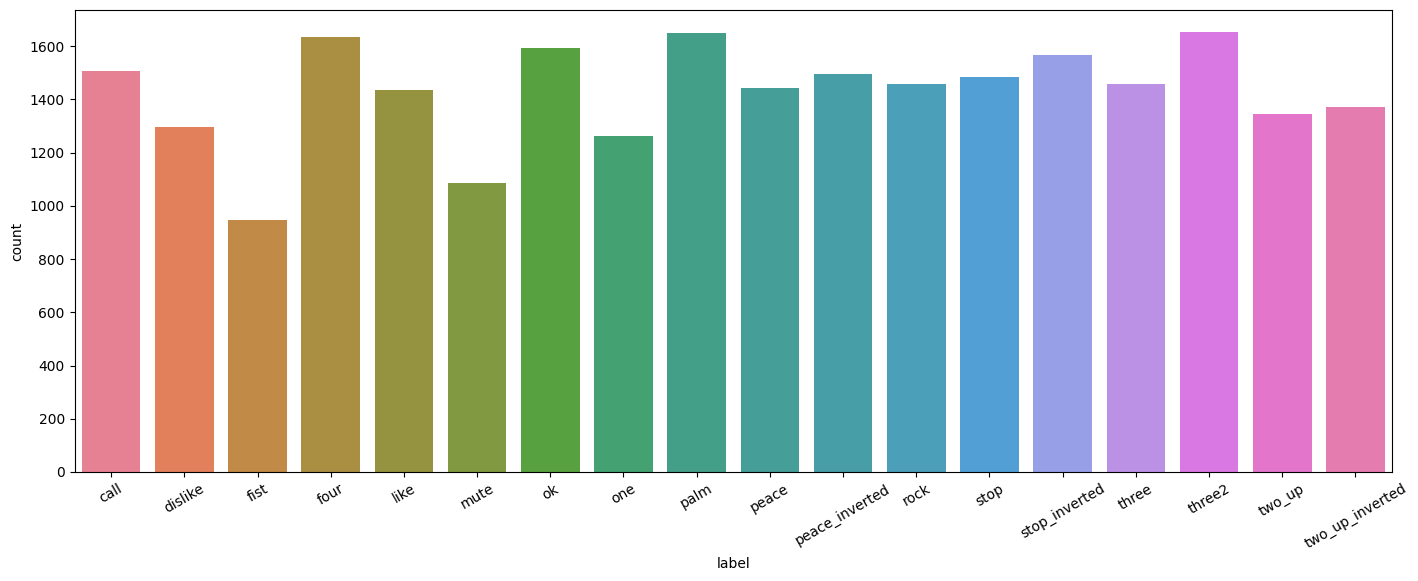

In [5]:
plt.figure(figsize=(17,6))
sns.countplot(data=df, x='label', hue='label')
plt.xticks(rotation=30)
plt.show()

So far we don't have any missing values or inconsistency in data types, our data contains 25675 rows and the data is quite unbalanced (we have shortage in fist & mute labels especially).

## Data Visualization

In [6]:
def plot_hand_landmarks(sample, ax=None):
    """
    Plot hand landmarks for a single sample.
    
    Parameters:
    -----------
    sample : pd.Series or dict
        A row from the dataframe containing x, y, z coordinates for 21 landmarks
    ax : matplotlib axis, optional
        Axis to plot on. If None, creates a new figure
    
    Returns:
    --------
    ax : matplotlib axis
        The axis with the plotted hand landmarks
    """
    # Extract x, y coordinates for all 21 landmarks
    x_coords = [sample[f'x{i}'] for i in range(1, 22)]
    y_coords = [sample[f'y{i}'] for i in range(1, 22)]
    
    # Create figure if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # MediaPipe hand landmark connections
    # Each tuple represents a connection between two landmark indices
    connections = [
        # Thumb
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Index finger
        (0, 5), (5, 6), (6, 7), (7, 8),
        # Middle finger
        (0, 9), (9, 10), (10, 11), (11, 12),
        # Ring finger
        (0, 13), (13, 14), (14, 15), (15, 16),
        # Pinky
        (0, 17), (17, 18), (18, 19), (19, 20),
        # Palm
        (5, 9), (9, 13), (13, 17)
    ]
    
    # Plot connections (lines between landmarks)
    for connection in connections:
        start_idx, end_idx = connection
        ax.plot([x_coords[start_idx], x_coords[end_idx]], 
                [y_coords[start_idx], y_coords[end_idx]], 
                'b-', linewidth=2, alpha=0.6)
    
    # Plot landmarks (points)
    ax.scatter(x_coords, y_coords, c='red', s=50, zorder=3)
    
    # Add landmark numbers
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        ax.annotate(str(i), (x, y), fontsize=8, ha='center', 
                   bbox=dict(boxstyle='circle,pad=0.1', facecolor='yellow', alpha=0.5))
    
    # Invert y-axis (image coordinates start from top-left)
    ax.invert_yaxis()
    
    # Set labels and title
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)
    ax.set_title(f'Hand Gesture: {sample["label"]}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    return ax

In [7]:
def plot_multiple_gestures(df, n_samples=6, random_state=42):
    """
    Plot multiple hand gesture samples for visual inspection.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing hand landmark data
    n_samples : int
        Number of samples to plot (default: 6)
    random_state : int
        Random seed for reproducibility
    """
    # Sample random gestures
    samples = df.sample(n=n_samples, random_state=random_state)
    
    # Calculate grid dimensions
    n_cols = 3
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_samples > 1 else [axes]
    
    # Plot each sample
    for idx, (_, sample) in enumerate(samples.iterrows()):
        plot_hand_landmarks(sample, ax=axes[idx])
    
    # Hide extra subplots if any
    for idx in range(n_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
def plot_gestures_by_label(df, labels=None, samples_per_label=3, random_state=42):
    """
    Plot hand gesture samples grouped by label for comparison.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing hand landmark data
    labels : list, optional
        List of gesture labels to plot. If None, plots all unique labels
    samples_per_label : int
        Number of samples to show per label (default: 3)
    random_state : int
        Random seed for reproducibility
    """
    # Get labels to plot
    if labels is None:
        labels = df['label'].unique()[:5]  # Limit to 5 labels for readability
    
    n_labels = len(labels)
    
    # Create subplots
    fig, axes = plt.subplots(n_labels, samples_per_label, 
                             figsize=(5 * samples_per_label, 5 * n_labels))
    
    # Handle single row/column case
    if n_labels == 1:
        axes = axes.reshape(1, -1)
    elif samples_per_label == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot samples for each label
    for row_idx, label in enumerate(labels):
        # Get samples for this label
        label_samples = df[df['label'] == label].sample(
            n=min(samples_per_label, len(df[df['label'] == label])), 
            random_state=random_state
        )
        
        for col_idx, (_, sample) in enumerate(label_samples.iterrows()):
            if col_idx < samples_per_label:
                plot_hand_landmarks(sample, ax=axes[row_idx, col_idx])
    
    plt.suptitle('Hand Gestures Grouped by Label', fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.show()

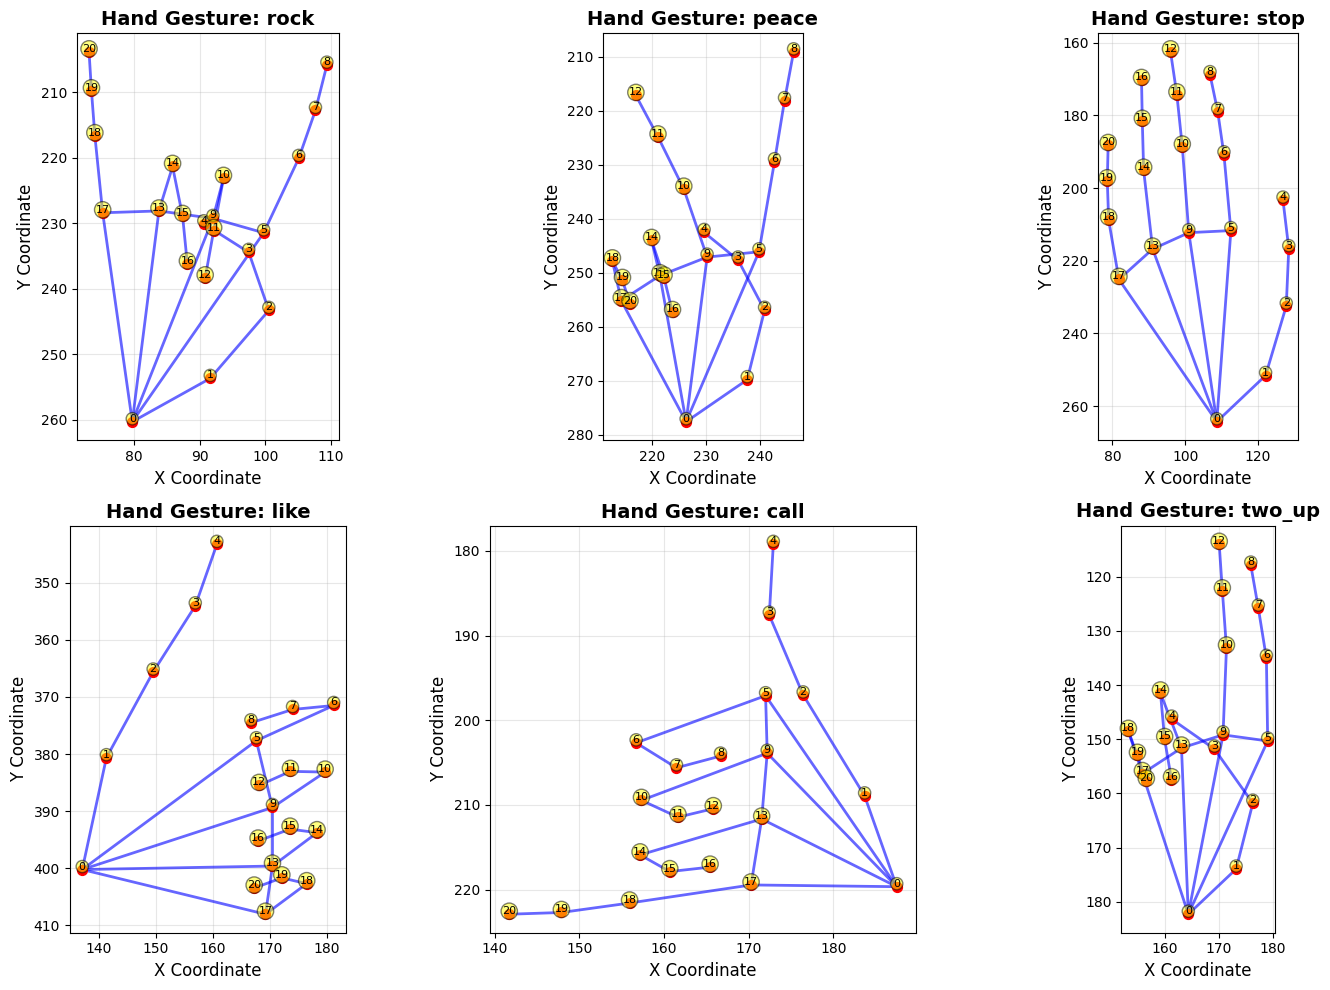

In [9]:
plot_multiple_gestures(df, n_samples=6)

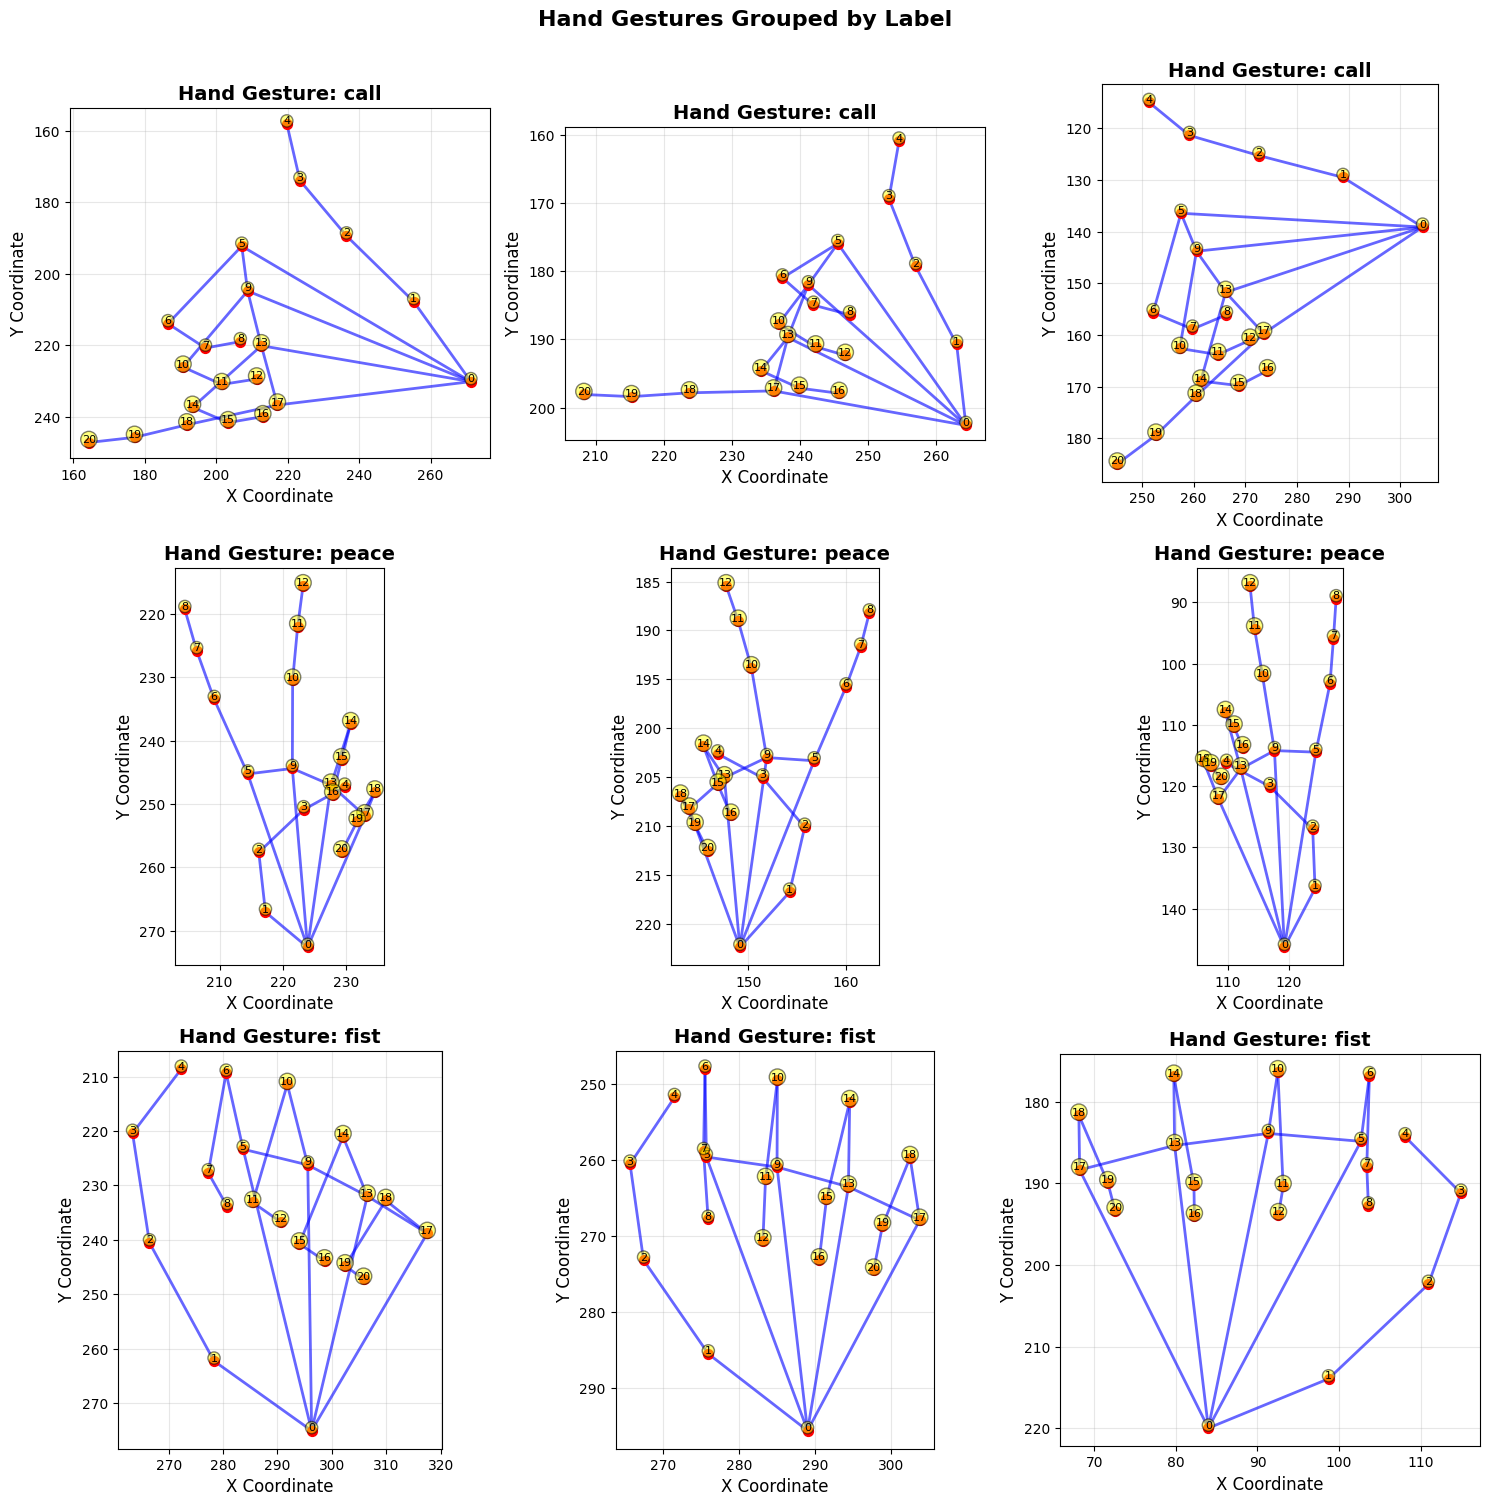

In [10]:
plot_gestures_by_label(df, labels=['call', 'peace', 'fist'], samples_per_label=3)

## Data Preprocessing

Before applying any operations on the dataset we are going to split the data to 80% training and 20% validation and the testing will be done real time on the output video this way we are preventing any data leakage risks.

Since we are having quite unbalanced data so it is prefered to use stratified sampling during splitting the data.

Additionally, the data should be shuffled before splitting since consecutive samples belong to the same gesture class.

In [11]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X.shape, y.shape

((25675, 63), (25675,))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20540, 63), (5135, 63), (20540,), (5135,))

The detected hands have different scales and positions in the image. To overcome this problem recenter the hand landmarks (x,y) to make the origin the wrist point and divide all the landmarks by the mid-finger tip position.

We are going to create a custom sklearn class that transfrom our data by subtracting the wrist coordinates from all other landmark coordinates and scale them by the position of the middle finger tip.

In [13]:
class LandmarkNormalizer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to normalize MediaPipe hand landmarks.
    - Recenters (x, y) coordinates to the wrist (Landmark 0).
    - Scales landmarks by the distance to the middle finger tip (Landmark 12).
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # No parameters to estimate here
        return self

    def transform(self, X):
        X_copy = np.copy(X)
        
        for i in range(len(X_copy)):
            # Reshape to (21, 3) for easier indexing: [landmark_idx, coordinate]
            landmarks = X_copy[i].reshape(21, 3)
            
            # Recenter: Subtract wrist (0) coordinates from all (x, y) 
            wrist = landmarks[0, :2] # Only x and y
            landmarks[:, :2] -= wrist
            
            # Scale: Divide by mid-finger tip (12) position
            scale_factor = np.linalg.norm(landmarks[12, :2])
            landmarks[:, :2] /= scale_factor
                
            # Flatten back to the original shape
            X_copy[i] = landmarks.flatten()
            
        return X_copy

Now we are going to test this transformer and create a new dataframe using the normalized data to visualize the landmarks after normalization and make sure very thing is working as expected.

In [14]:
normalizer = LandmarkNormalizer()
X_train_normalized = normalizer.fit_transform(X_train)

In [15]:
df_normalized = pd.DataFrame(data=np.column_stack([X_train_normalized, y_train]), columns=df.columns)

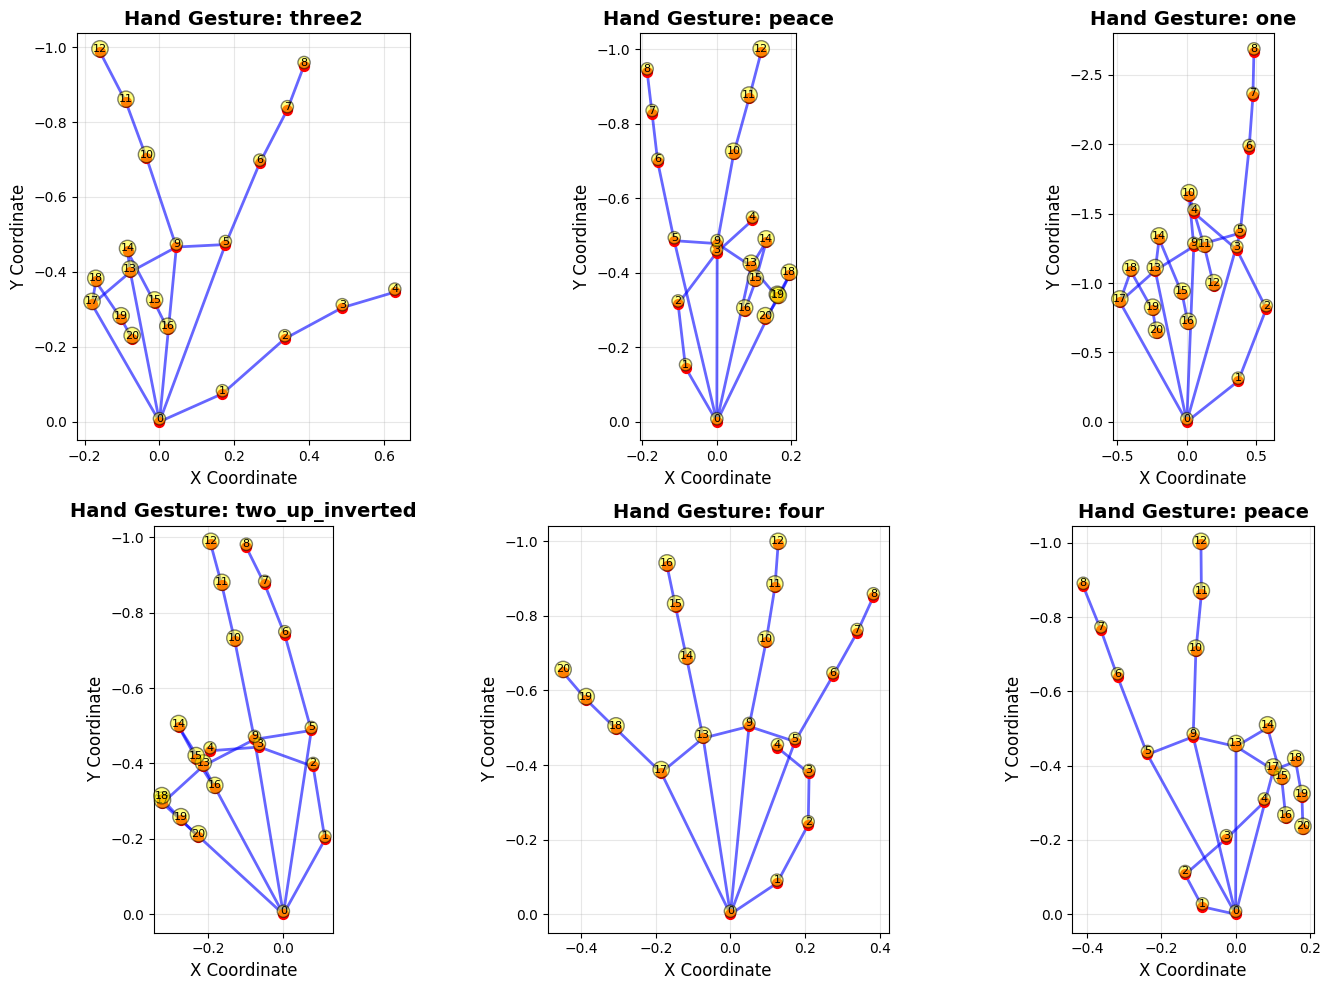

In [16]:
plot_multiple_gestures(df_normalized, n_samples=6)

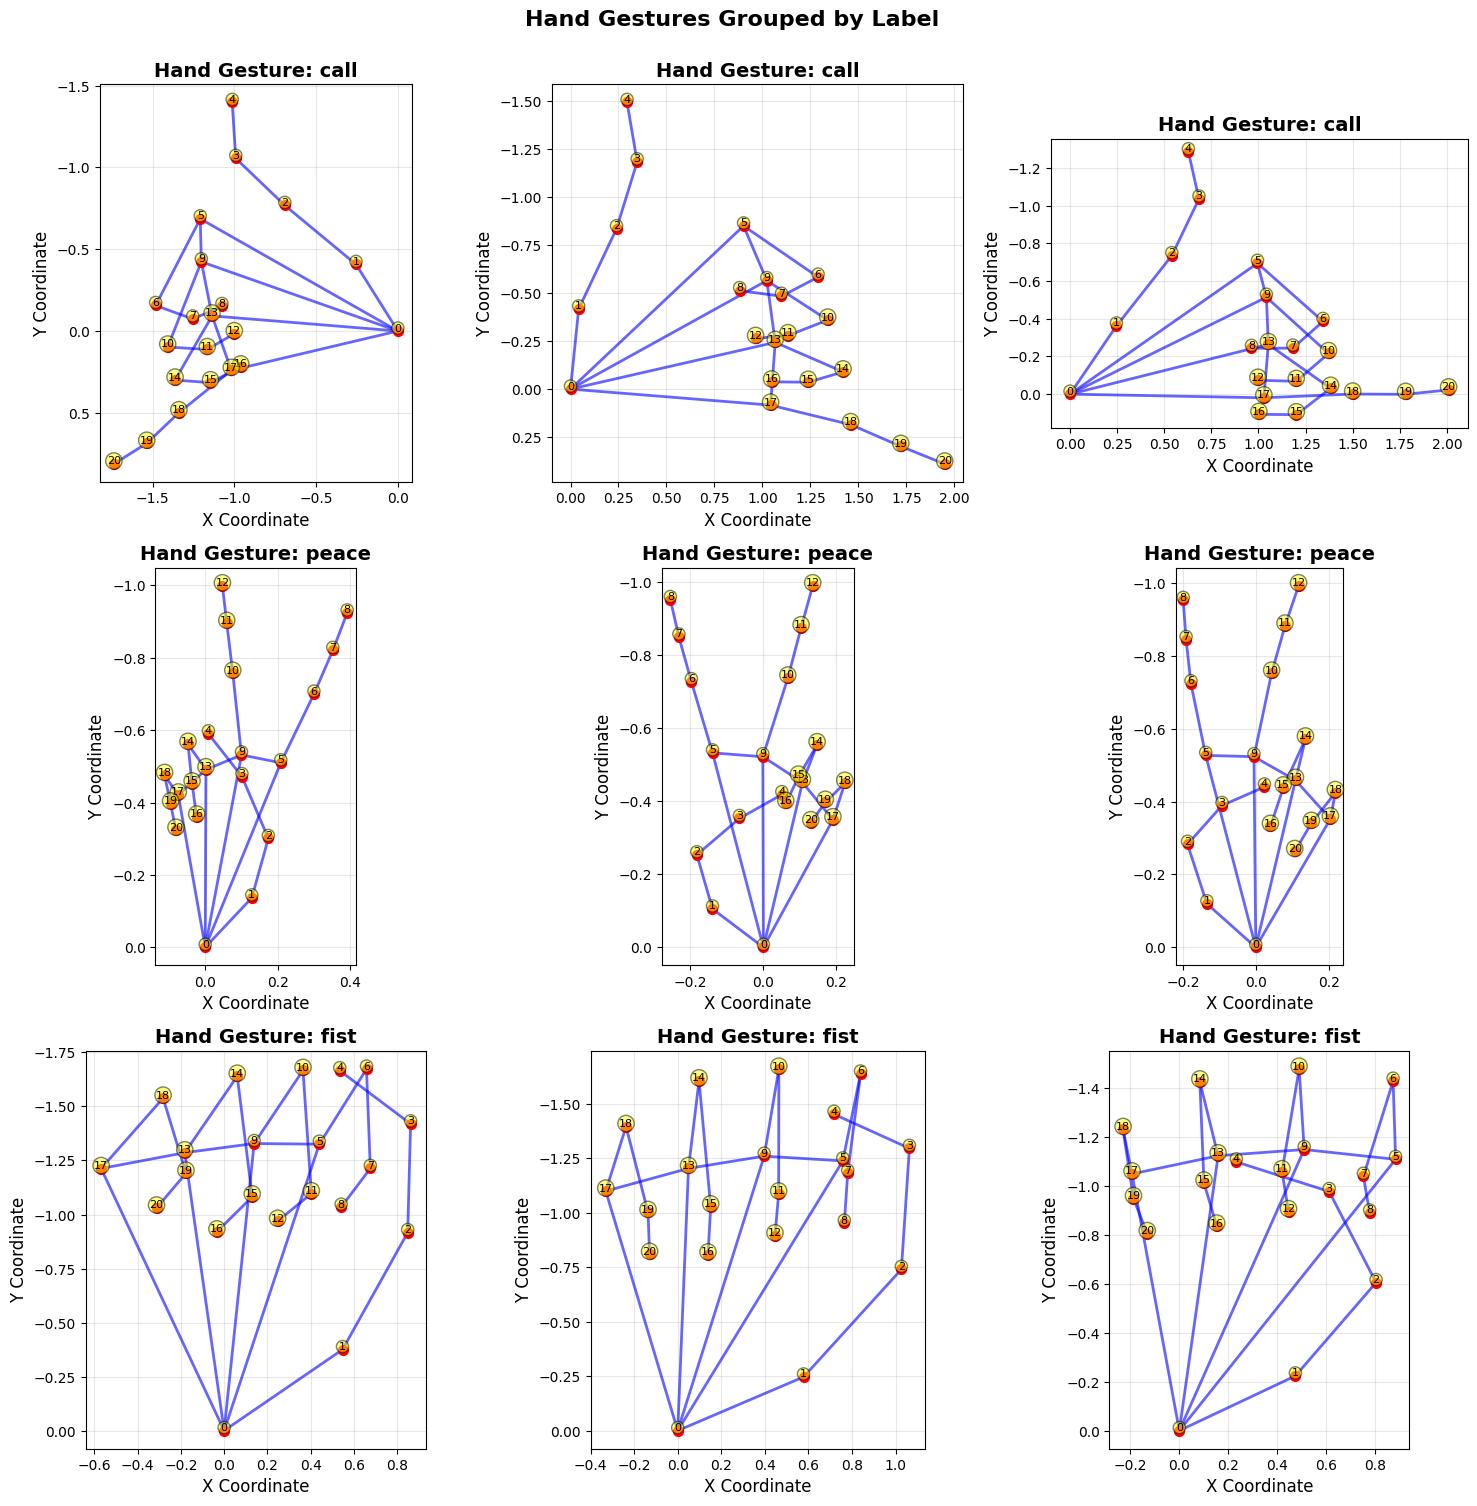

In [17]:
plot_gestures_by_label(df_normalized, labels=['call', 'peace', 'fist'], samples_per_label=3)

As you see the wrist landmark is at zero and all other landmarks are correctly scaled without changing the aspect ratio of the hand this makes our model scale and translation invariant.

## Model Training & Evaluation

In this section, we are going to train three different models using k-fold cross validation and grid search for hyperparameter tuning:

1. **K-Nearest Neighbors (KNN)**: A distance-based classifier that predicts based on the majority class of the k nearest neighbors.

2. **Logistic Regression**: A linear model that uses a logistic function to model the probability of each gesture class.

3. **Random Forest**: An ensemble learning method that constructs multiple decision trees and outputs the mode of their predictions.

For each model, we will:
- Perform grid search to find the best hyperparameters
- Use 5-fold cross-validation to evaluate performance during training
- Test the best model on the hold-out test set
- Visualize results using confusion matrices and classification metrics

In [18]:
X_test_normalized = normalizer.transform(X_test)

### K-Nearest Neighbors Classifier

In [19]:
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

best_score = 0
best_params = None

for param in ParameterGrid(param_grid):
    knn = KNeighborsClassifier(**param)
    scores = cross_val_score(knn, X_train_normalized, y_train, cv=5)

    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_params = param

print(f"Best Params: {best_params}, Best CV Accuracy: {best_score:.4f}")

Best Params: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}, Best CV Accuracy: 0.9757


In [20]:
knn = KNeighborsClassifier(**best_params)
best_model = knn.fit(X_train_normalized, y_train)
preds = best_model.predict(X_test_normalized)

report = classification_report(y_test, preds, output_dict=True)
print(f"Accuracy: {report['accuracy']:.4f}")
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

Accuracy: 0.9772
Precision: 0.9775
Recall: 0.9772
F1-score: 0.9773


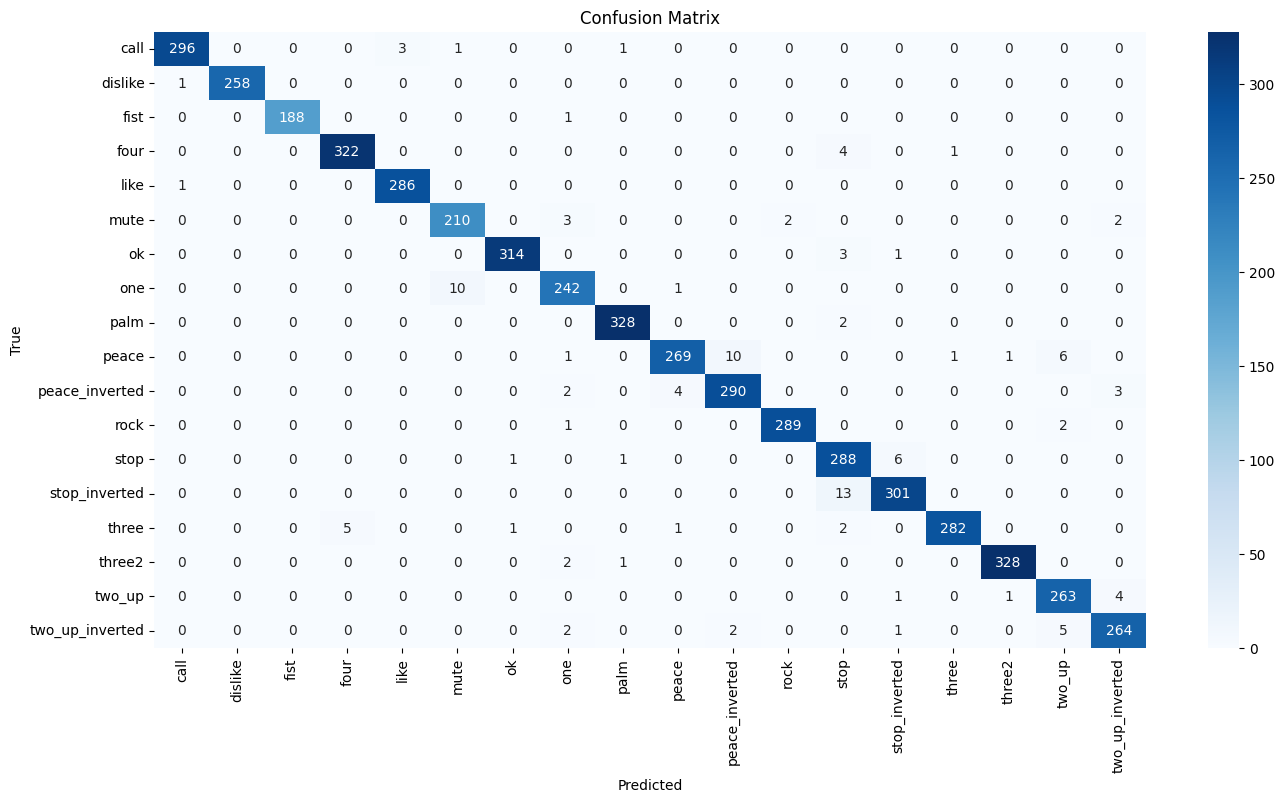

In [21]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(16, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Logistic Regression Classifier

In [22]:
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', None],
    'max_iter': [500, 1000]
}

best_score = 0
best_params = None

for param in ParameterGrid(param_grid):
    lr = LogisticRegression(**param, random_state=42)
    scores = cross_val_score(lr, X_train_normalized, y_train, cv=5)

    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_params = param

print(f"Best Params: {best_params}, Best CV Accuracy: {best_score:.4f}")

Best Params: {'C': 0.1, 'max_iter': 1000, 'penalty': None}, Best CV Accuracy: 0.9266


In [23]:
lr = LogisticRegression(**best_params, random_state=42)
best_model = lr.fit(X_train_normalized, y_train)
preds = best_model.predict(X_test_normalized)

report = classification_report(y_test, preds, output_dict=True)
print(f"Accuracy: {report['accuracy']:.4f}")
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

Accuracy: 0.9307
Precision: 0.9309
Recall: 0.9307
F1-score: 0.9306


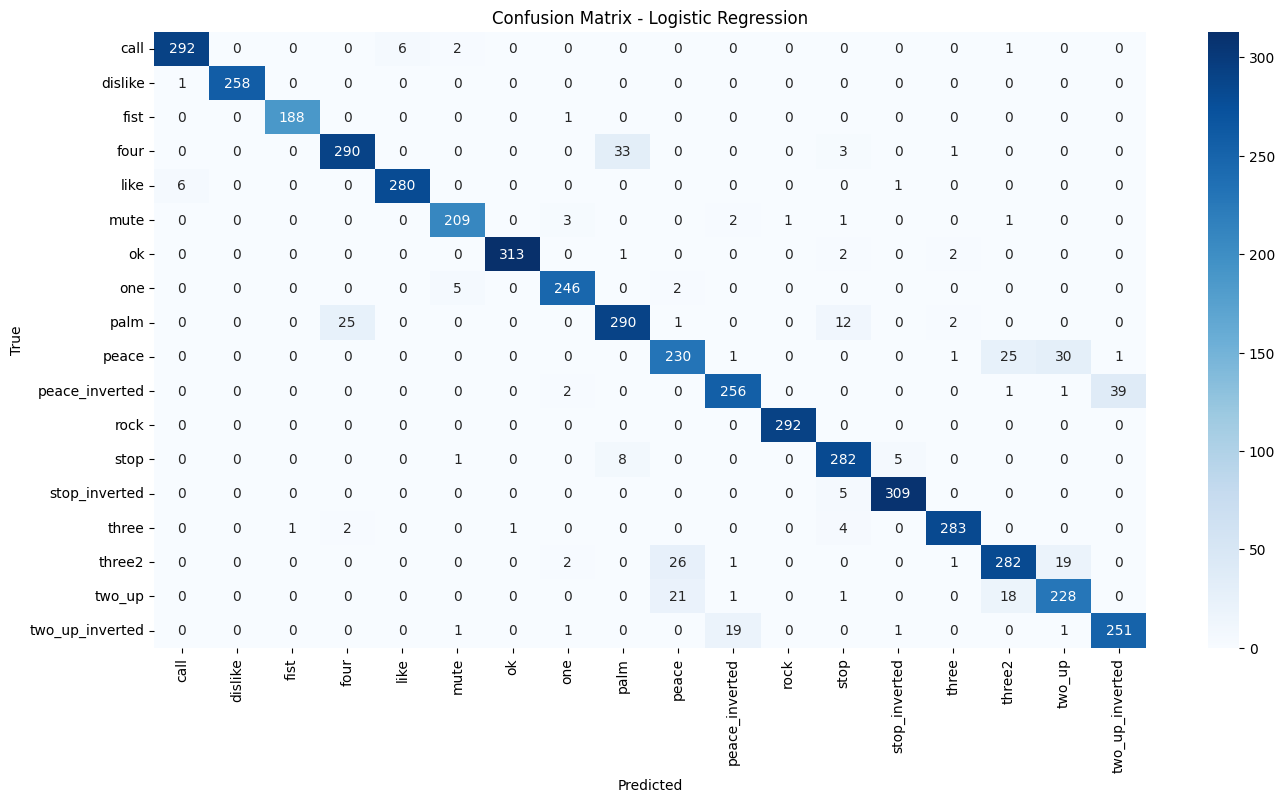

In [24]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(16, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

### Random Forest Classifier

In [25]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

best_score = 0
best_params = None

for param in ParameterGrid(param_grid):
    rf = RandomForestClassifier(**param, random_state=42)
    scores = cross_val_score(rf, X_train_normalized, y_train, cv=5)

    if np.mean(scores) > best_score:
        best_score = np.mean(scores)
        best_params = param

print(f"Best Params: {best_params}, Best CV Accuracy: {best_score:.4f}")

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}, Best CV Accuracy: 0.9762


In [26]:
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_normalized, y_train)
preds = best_model.predict(X_test_normalized)

report = classification_report(y_test, preds, output_dict=True)
print(f"Accuracy: {report['accuracy']:.4f}")
print(f"Precision: {report['weighted avg']['precision']:.4f}")
print(f"Recall: {report['weighted avg']['recall']:.4f}")
print(f"F1-score: {report['weighted avg']['f1-score']:.4f}")

Accuracy: 0.9792
Precision: 0.9794
Recall: 0.9792
F1-score: 0.9792


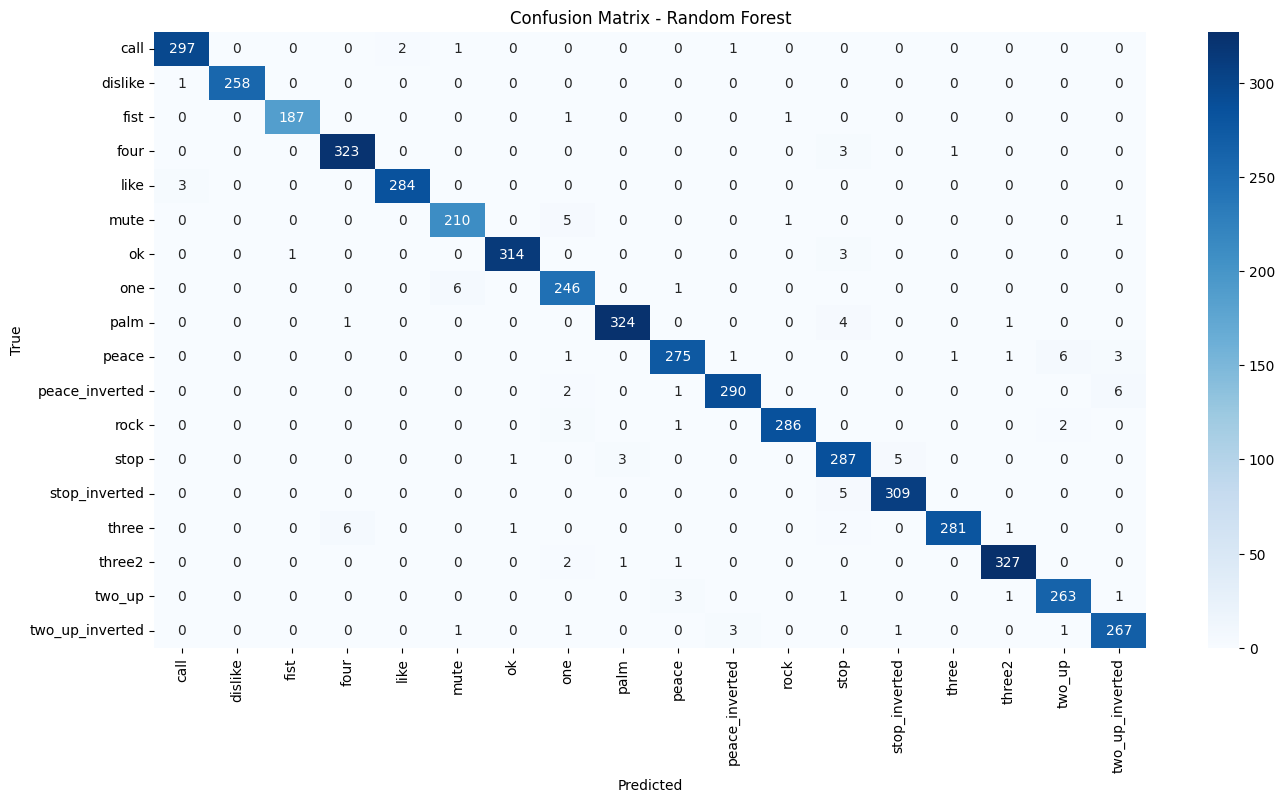

In [27]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(16, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()